# Ziel
Im Tutorial 2 von www.pv4ing.ch sind drei Übungen vorgesehen. Die erste Übung erstellt eine Zeitreihe mit fiktiven Daten. Die zweite Übung verwendet Messdaten als Zeitreihe und die dritte Übung führt eine Berechnung der Jahresstrahlungsenergie durch, bei unterschiedlichen Ausrichtungen.

# Tutorial 2 - Übung 1: Einstieg
Zuerst machen wir eine einfache Zeitreihenrechnung.

## Schritt 1 - Synthetische Messwerte für 1 Tag
Im folgenden Beispiel, nehmen wir keine realen Messwerte, sondern "bauen" uns selbst die Messwerte über die Sinusfunktion. Zuerst erstellen wir einen Array (Zahlenreihe) für die Zeit. Wir nehmen an, dass die Sonne um 6:00 aufgeht und um 18:00 untergeht. Über Mittag erre
icht die Strahlung einen Wert von 650 W/m2. 


In [1]:
# Bibliotheken Import
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Funktionsdefinition (benötigen wir später)
cos  = lambda arg : np.cos(np.deg2rad(arg))
sin  = lambda arg : np.sin(np.deg2rad(arg))
acos = lambda arg : np.rad2deg(np.arccos(arg))
asin = lambda arg : np.rad2deg(np.arcsin(arg))

t = np.linspace(6,18,1000)
H = 650 * sin((t-6)/(18-6)*180)

Strahlungsarray (Zahlenreihe für die Strahlung in W/m2). Beachte das die Funktion sin() oben mit dem lambda-Operator definiert wurde und in Grad angegeben wird. Dies ist nicht bei der Funktion np.sin() der Fall.

Überprüfe ob der Zeitarray aus lauter Spaltenwerte (Zeile mit vielen Zahlen) oder aus lauter Zeilenwerte (Spalte mit vielen Zahlen) besteht. Spalte = column. Zeile = row.

In [2]:
np.shape(t)

(1000,)

Stelle den Strahlungsverlauf als figure mit der Linienfarbe grün (g=green) dar.

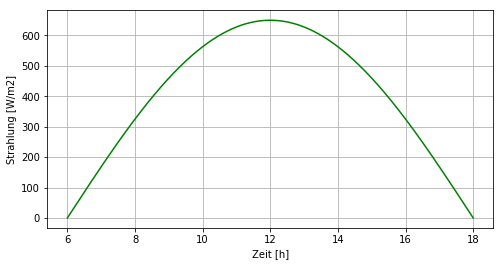

In [3]:
plt.figure(2, figsize=(8,4))
plt.plot(t,H, 'g')
plt.xlabel('Zeit [h]')
plt.ylabel('Strahlung [W/m2]')
plt.grid()

Nun können wir die Strahlungsenergie $W_H$ für diesen einen Tag berechnen. Beachte das die Berechung der "Energie = Leistung mal Zeit" ist. Hier ist der Zeitschritt "deltaT".

In [4]:
A = 1 # Fläche 1 m2
deltaT = t[1] - t[0]
wH = np.sum(H)*deltaT*A/1000
print('Strahlungsenergie [kWh/m2/Tag]: ' + str(wH))

Strahlungsenergie [kWh/m2/Tag]: 4.965630132215672


Nun haben wir folgende Punkte gelernt:
1. Erstellen eines Arrays.
2. Darstellen von Arrays, inklusiv Beschriftung.
3. Berechnen eines Flächenintegrals aus diskreten Werten, d.h. Aufsummieren von Werten.

## Schritt 2 - Synthetische Messwerte für 7 Tag
Nun wollen wir die Strahlungsenergie von 7 Tagen berechnen, von Stunde 0 bis Stunde 7 x 24. Die Sinusfunktion liefert uns für die Nacht (18:00 bis 6:00) negative Werte. Wir korrigieren die negativen Strahlungswerte zu 0.

In [5]:
H[H<0] = 0

Der Ausdruck "H<0" generiert ein Selektor-Array der Länge von H, bei dem die Positionen mit "1" oder "True" gekennzeichnet sind, bei welchen der Wert < 0 ist. Der Ausdruck H[Selektor-Array] = 0 weisst allen selektierten Positionen eine 0 zu. 

Denkbar ist auch "M[N<1] = 2". M und N müssen gleich lange Arrays sein. Im Array M werden alle Stellen auf 2 gesetzt, bei denen der Wert im Array N < 1 ist.

# Tutorial 2 - Übung 2: Berechnung Strahlungsenergie von mehreren Tagen mit Messdaten
Nun verwenden wir nicht "künstliche" Strahlungswerte (generiert durch die Sinusfunktion), sondern reale Messwert. Hierzu benötigen wir eine Datendatei. Wir erstellen einen Plot über 7 Tage mit der Globalstrahlung "hGlob", der Diffusstrahlung "hDif" und der Direktstrahlung "hDir". 

Bei Energiesimulationen ist es empfehlenswert als Kommentar die Einheit anzugeben, sodass verständlich ist um was es sich handelt, z.B. [grad] oder [radiant] oder [W]  oder [kWh].

Verwende für diese Übung ein neues py-File.

Zuerst importieren wir die "datetime"-Bibliothek, welche wir für Berechnungen im Zeitformat benötigen. Es gibt viele Möglichkeiten Daten zu importieren, vermutlich auch elegantere. Wir verwenden zum Import der csv-Daten "loadtxt" von der numpy-Bibliothek, dabei importieren wir das Datumsformat (als Unicode-String) separat von den Zahlen (float). 

Die csv-Datei ist auf github [https://github.com/markstaler/pv4ing](https://github.com/markstaler/pv4ing). 

In [6]:
# Datenimport
data   = np.loadtxt('2017_DataExport15min.csv', dtype='f', delimiter=';', skiprows = 1, usecols = [1,2,3,4,10])
hGlo   = data[:,0]  # [W/m2] 
hDif   = data[:,1]  # [W/m2]
tAmb   = data[:,2]  # [W/m2]
pLoad  = data[:,3]  # [W] Verbrauchsprofil
zapf   = data[:,4] # [l/15min] Profil für Warmwasserbezug

tutcIn = np.loadtxt('2017_DataExport15min.csv', dtype='U', delimiter=';', skiprows = 1, usecols = [0])
tutc = [] # leere Liste
for t in range(tutcIn.size):
    tutc.append(dt.datetime.strptime(tutcIn[t], '%Y-%m-%d %H:%M:%S'))
tutc = np.array(tutc) # umwandeln in ein numpy Array

So haben wir "tutc" als einen Array in datetime-Format. Zusätzlich erzeugen wir nun einen Array mit laufenden Stunden, beginnend mit Stunde 0 bei Jahresamfang. Diesen benötigen wir aber erst später zur Sonnenstandsberechung.

In [7]:
lfStd = np.zeros(tutc.size)
for t in range(tutc.size):
    # berechnet laufender Tag im Jahr
    noDay = (tutc[t] - dt.datetime(tutc[0].year, 1, 1, 0)).days 
    # [h] berechnet laufende Stunde im Tag
    noHou = tutc[t].hour + (tutc[t].minute)/60.0 + (tutc[t].second)/3600.0 
    lfStd[t] = noDay*24 + noHou
    
deltaT = lfStd[1] - lfStd[0] # [h]

## Schritt 1
Es soll die Globalstrahlung in grün, Direktstrahlung in rot und Diffusstrahlung in blau dargestellt werden. Weiter soll in der Plot-Figure eine Legende mit den Kurvennamen dargestellt werden. Als Ausschnitt wollen wir die ersten 7 Tage betrachten, d.h. in der Plotfunktion grenzen wir den Array ein durch tutc[a:e], wobei a für den Anfangsindex und e für den Endindex steht.

## Schritt 2
Wenn wir den ersten Tag im Plot ansehen, so fällt auf, dass negative Strahlungswerte vorkommen. Dies entspricht den Messergebnissen aber nicht der Realität. Deshalb sollen die Strahlungsdaten bereinigt werden.
 

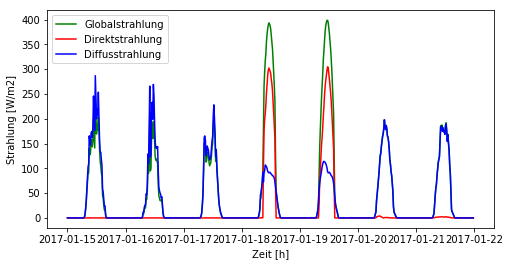

In [8]:
hDir = hGlo - hDif

hDir[hDir<0] = 0  # wichtig
hDif[hDif<0] = 0  # wichtig
hGlo[hGlo<0] = 0  # wichtig

a=int(0)           # Anfangstag
e=int(7*24/deltaT) # Endtag

plt.figure(3, figsize=(8,4))# Grösse des Plots (figsize) in Zoll
plt.plot_date(tutc[a:e],hGlo[a:e],'g', label ='Globalstrahlung')
plt.plot_date(tutc[a:e],hDir[a:e],'r', label ='Direktstrahlung')
plt.plot_date(tutc[a:e],hDif[a:e],'b', label ='Diffusstrahlung')
plt.xlabel('Zeit [h]');
plt.ylabel('Strahlung [W/m2]');
plt.legend(loc="upper left")

# Schritt 3
Nun berechnen wir die Strahlungsenergie über das gesamte Jahr.

In [9]:
wGlo = np.sum(hGlo)*deltaT/1000 # [kWh/m2] Jahresstrahlungsenergie Globalstrahlung
wDir = np.sum(hDir)*deltaT/1000 # [kWh/m2] Jahresstrahlungsenergie Direktstrahlung
wDif = np.sum(hDif)*deltaT/1000 # [kWh/m2] Jahresstrahlungsenergie Diffusstrahlung
print('Jahrl. Energie Globalstrahlung ' + str(wGlo) + ' kWh/m2 entspricht ' + str(wGlo/wGlo*100) + ' %')
print('Jahrl. Energie Direktstrahlung ' + str(wDir) + ' kWh/m2 entspricht ' + str(wDir/wGlo*100) + ' %')
print('Jahrl. Energie Diffusstrahlung ' + str(wDif) + ' kWh/m2 entspricht ' + str(wDif/wGlo*100) + ' %')

Jahrl. Energie Globalstrahlung 1208.622875 kWh/m2 entspricht 100.0 %
Jahrl. Energie Direktstrahlung 687.0435 kWh/m2 entspricht 56.8451511394735 %
Jahrl. Energie Diffusstrahlung 528.3301875 kWh/m2 entspricht 43.71340295044474 %


Zur Kontrolle vergleiche die Jahresglobalstrahlungsenergie für diesen Standort mit den Werten aus PVGIS. Um anstatt der Jahresstrahlungsenergie die elektrische Energie aus einem Modul zu berechnen ist der Modulwirkungsgrad und die Modulfläche notwendig. Es muss noch der Temperatureinfluss und die Reflexionsverluste berücksichtigt werden. Theorie hierfür ist im Manuskript "Photovoltaik für Ingenieure" Kapitel "Kennwerte Photovoltaik".

Nun haben wir folgende Punkte gelernt:
1. Bereinigen eines Array (z.B. Nullsetzten bei negativen Werten).
2. Importieren von Messdaten.
3. Berechnen der Strahlungskomponente hDir aus hGlob und hDiff.
4. Darstellen der Kurven in einem Plot-Figure über eine Zeitachse, inklusiv einer Legende.
5. Berechnen der JahresENERGIE aus der Jahresleistung über deltaT und aufsummieren.


# Tutorial 2- Übung 3: Strahlung auf eine geneigte Fläche
Bisher betrachteten wir die Strahlung auf die Horizontale. Horizontal weil die Messgeräte horizontal aufgestellt sind. Über die Aufteilung der Globalstrahlung in Diffus- und Direktstrahlung kann die Strahlung auf eine beliebige Fläche berechnet werden.

## Schritt 1
Hierfür wird das Dreikomponentenmodell verwendet, welches den Sonnenstand benötigt. Wie das Dreikomponentenmodell und der Sonnenstand berechnet wird, ist im Manuskript "Photvoltaik für Ingenieure" beschrieben. Hier der Code zur Berechnung der Jahresstrahlungsenergie bei unterschiedlicher Modul-Neigung und Azimut = 0° (Süden). 7 Code-Zeilen für den Sonnenstand und 7 Code-Zeilen für das Strahlentransformationsmodell.

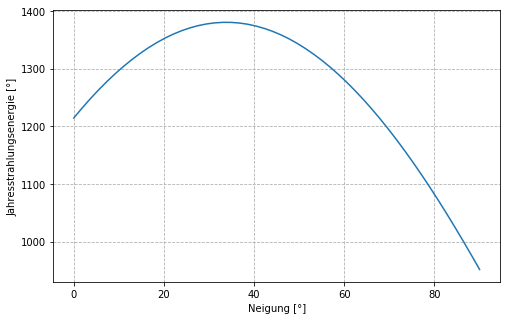

In [11]:
# Parameterdefinition
lg = 9.4     # [grad] Längengrad Buchs
bg = 47.17   # [grad] Breitengrad Buchs
al = 0.2     # [1] Albedo-Faktor
aziFl = 0    # [grad] Azimut Modulfläche

# Sonnenstand
dekl = 23.45*cos(360/(365*24)*(lfStd - 173*24))     # [grad] Deklination
omega = 15 * lfStd + lg - 180                       # [grad] Stundenwinkel laufend
omega = np.mod(omega + 180, 360) - 180              # [grad] Stundenwinkel -180° bis 180°
h = asin(sin(dekl)*sin(bg) + cos(dekl)*cos(bg)*cos(omega)) # [grad] Sonnenhöhe
azi = acos((sin(h)*sin(bg) - sin(dekl))/(cos(h)*cos(bg)))
azi = np.sign(omega)*azi

h[h<0] = 0
neigung = np.linspace(0,90,50) # [grad] Neigung
wH = np.zeros(neigung.size) # Initialisierung
for n in range(neigung.size):
    neig = neigung[n]
    
    # Strahlentransformationsmodell
    cosTheta = cos(neig)*sin(h) + sin(neig)*cos(h)*cos(azi - aziFl)
    cosTheta[cosTheta<0] = 0
    hDifFl = hDif*(1 + cos(neig))/2
    hAlbFl = hGlo*al*(1 - cos(neig))/2
    hDirFl = hDir/np.maximum(sin(h), sin(5))*cosTheta
    hFl = hDirFl + hDifFl + hAlbFl
    wH[n] = np.sum(hFl)*deltaT/1000 # [kWh/m2] Jahresstrahlungsenergie    
    
# Darstellung
fig  = plt.figure(1, figsize=(8,5))
plt.plot(neigung, wH)
plt.xlabel('Neigung [°]')
plt.ylabel('Jahresstrahlungsenergie [°]')
plt.grid(which='both', linestyle='--')

Aufbau des Code-Beispiels: Für die unterschiedlichen Neigungen wird eine for-Schleife, um den Berechnungscode fürs Strahlentransformationsmodell gelegt. Innerhalb der for-Schleife wird die Leistung übers gesamte Jahr berechnet und für die Jahresenergie (wH) mit deltaT multipliziert und aufsummieren. Weiter wird die Summe durch 1000 geteilt um kWh anstatt Wh zu erhalten.

Weitere Hinweise zum Code:
 - Bei der Berechnung des Direktstrahlungsanteils ist eine Division von sin(h) notwendig. Wenn h = 0 ist, führt dies zu Problemen in der Berechnung, weshalb die Werte auf eine Sonnenhöhe von $5^\circ$ limitiert werden. Implementierung sieht wie folgt aus, anstatt sin(h) wird np.maximum(sin(h),sin(5)) verwendet.
 - Bei der Python-Implementierung ist darauf zu achten das "np.maximum()" verwendet wird, anstatt "max"! Diese Funktionen sind nicht identisch. Überprüfe den Unterschied. np.maximum ermittelt elementweise das Maximum bei zwei Array's.
 - Bei der Berechnung der Direktstrahlungskomponente wird der Zwischenwinkel $\Theta$ benötigt. Ist dieser über 90° heisst dies das die Direktstrahlung hinter dem Modul ist. Deshalb müssen diese Werte korrigiert werden.

    theta[theta>90] = 90
    
    Bei genauerer Betrachtung der Berechnung ist nicht $\Theta$ in der Berechnung notwendig, sondern $cos(\Theta)$. Die Korrektur sieht dann wie folgt aus:

    cosTheta[cosTheta<0] = 0

Zur Kontrolle:
 - Stelle den Sonnenstand dar (Azimut und Sonnenhöhe)
 - Vergleiche die Ergebnisse mit PVGIS für den berechneten Standort Buchs. Beachte das die Jahresstrahlungsenergie in kWh/m2 angegeben wird. In PVGIS ist dies "H" nicht "E". Trage die PVGIS-Werte ebenfalls ins Diagramm ein.

## Schritt 3
*** Aufgabe Optimale Ausrichtung: *** Variieren wir nicht einen Parameter, wie oben die Neigung, sondern einen zweiten Parameter, den Azimut, so lässt sich das Ergebnis als 3D-Plot darstellen oder als Contour-Plot. 

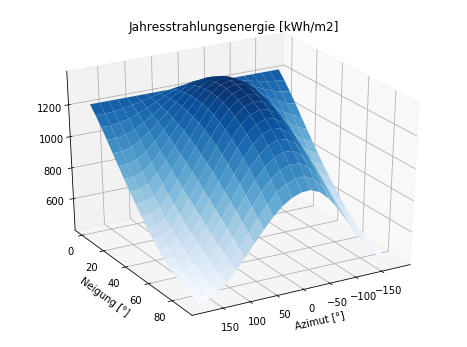

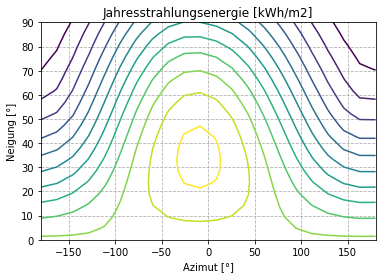

In [16]:
#################
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#################

neigung = np.linspace(0,90,20)
aziFlae = np.linspace(-180,180,22)
wH = np.zeros((neigung.size, aziFlae.size))
for n in range(neigung.size):
    for a in range(aziFlae.size):
        neig  = neigung[n]
        aziFl = aziFlae[a]
        
        # Strahlentransformationsmodell
        cosTheta = cos(neig)*sin(h) + sin(neig)*cos(h)*cos(azi - aziFl)
        cosTheta[cosTheta<0] = 0
        hDifFl = hDif*(1 + cos(neig))/2
        hAlbFl = hGlo*al*(1 - cos(neig))/2
        hDirFl = hDir/np.maximum(sin(h), sin(5))*cosTheta
        hFl = hDirFl + hDifFl + hAlbFl
        wH[n,a] = np.sum(hFl)*deltaT/1000 # [kWh/m2] Jahresstrahlungsenergie    
    
# Darstellung Surfcae-Plot
fig = plt.figure(1, figsize=(8,6))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(aziFlae,neigung)
surf = ax.plot_surface(X, Y, wH, \
                       rstride=1, cstride=1,\
                       cmap=cm.Blues, linewidth=0.2)
plt.xlabel('Azimut [°]')
plt.ylabel('Neigung [°]')
plt.title('Jahresstrahlungsenergie [kWh/m2]')
ax.view_init(azim=60, elev=29)

# Darstellung Contour-Plot
fig = plt.figure(2, figsize=(6,4))
CS = plt.contour(X, Y, wH, 15) # 15 Linien
plt.xlabel('Azimut [°]')
plt.ylabel('Neigung [°]')
plt.title('Jahresstrahlungsenergie [kWh/m2]')
plt.grid(which='both', linestyle='--')

### Zusammenfassung
Es wird für jeden Zeitpunkt eine Leistungsberechnung durchgeführt und am Ende des Jahres aufsummiert und mit dem Zeitschritt multipliziert. Somit wird die Jahresenergie berechnet (Energie = Leistung mal Zeit).

Die Berechnung der Jahresenergie erfolgt vektoriell.

Es werden nun mehrere Jahressimulationen durchgeführt für unterschiedliche Neigungen und für unterschiedliche Ausrichtungen, deshalb ist die Jahresberechnung in zwei for-Schleifen eingebettet.

# Information zur Simulation von einem Speicher
Für die Simulation einer Batterie ist neben der Produktion durch PV auch der Verbrauch relevant. Deshalb ist bei den Messdaten ein Lastprofil (pLoad) aufgeführt. Das Lastprofil ist syntetisch erstellt aus folgenden Verbrauchern.

<img src="loadProfile.png" style="width: 600px;">

Bei der Betrachtung von Produktion oder Verbrauch konnten die Zeitreihen als Array vektoriell berechnet werden, was die Simulation sehr effizient machte. Bei der Berechnung des Ladezustands einer Batterie ist der vorgängige Zustand relevant, d.h. es kann nicht mehr vektoriell gerechnet werden, sondern über eine Schleife. 

Bei der Berechnung wird jeder einzelne Zeitschritt berechnet:

#### 1. Berechnung Leistungsbedarf  (Verbrauch abzüglich Produktion)

Prüfen ob Leistungsbedarf durch die Batterie zur Verfügung gestellt werden kann:

a.) Wenn ja wird die Batterie entladen
        
b.) Wenn nicht wird die Leistung aus dem Netz bezogen, abzüglich dem Rest in der Batterie
        
#### 2. Berechnung Überschuss (Produktion abzüglich Verbrauch)

Prüfen ob Batterie nicht voll ist,

a.)	Wenn nicht kann die Batterie geladen werden bis sie voll ist, der Rest wird ins Netz rückgespeist
    
b.)	Wenn die Batterie voll ist, wird der Überschuss ins Netz rückgespeist.


   

Mit diesem Vorgehen wird die Netzbezugsenergie (wBez) und die Netzeinspeisung (wEin) berechnet (Energie = Leistung mal Zeit).

*** Spätestens hier ist es sehr wichtig, wenn als Kommentar die Einheit angegeben wird, um Klarheit zu haben ob Leistung [W] oder Energie [kWh] oder [Wh] gemeint ist! ***

In [12]:
### Parameterdefinition
PR          = 0.75 #[1]
pPVstc      = 2  #[kW]
batCap      = 2  #[kWh]

pPV      = hGlo*PR*pPVstc # [W] PV-Produktionsleistung
pVer     = pLoad               # [W] Verbrauchsprofil

### Batterie Berechnung
wBez  = 0    # [kWh] Energie Netzbezug
wEin  = 0    # [kWh] Energie Netzeinspeisung   
wBat  = 0    # [kWh] Energie Batteriestand. Annahme das Batterie zu Beginn leer ist

pBedarf = pVer-pPV  # [W] Bedarf ist Verbrauch agzüglich Produktion, jedoch....
pBedarf[pBedarf<0]=0 #...darf der Wert nicht <0 sein (z.B. wenn PV grösser ist als Verbrauch)
for p in range(pPV.size):    
    if wBat >= pBedarf[p]*deltaT/1000:
        wBat = wBat - pBedarf[p]*deltaT/1000    # [kWh]
    else:
        wBez = wBez + pBedarf[p]*deltaT/1000 - wBat   # [kWh]
        wBat  = 0
    pUebersch = np.maximum(pPV[p]-pVer[p], 0) # [W]      
    if wBat <= batCap:
        eNichtladbar = np.maximum(pUebersch*deltaT/1000 - (batCap-wBat),0) #[kWh]
        wBat = wBat + pUebersch*deltaT/1000 - eNichtladbar                 #[kWh] 
        wEin = wEin + eNichtladbar
    else:
        wEin = wEin + pUebersch*deltaT/1000   # [kWh]

wVer = np.sum(pVer)*deltaT/1000 # [kWh] Verbrauch Jahresenergie
wPro = np.sum(pPV)*deltaT/1000  # [kWh] PV-Produktion Jahresenergie
rEV = (wPro-wEin)/wPro *100 # [%] Eigenverbrauchsquote
rA = (wVer-wBez)/wVer *100 # [%] Autarkiegrad
print('Eigenverbrauchsgrad ist '+str(rEV)+' %')
print('Autarkiegrad ist '+str(rA)+' %')

Eigenverbrauchsgrad ist 79.42459867928004 %
Autarkiegrad ist 36.08505197435281 %


Mit dem obigen Code-Beispiel haben wir die Jahresenergie berechnet. Möchten wir einen zeitlichen Verlauf des Ladens und Entladens darstellen an drei Tagen im Jahr, so wird der Code erweitert, markiert mit (\***):

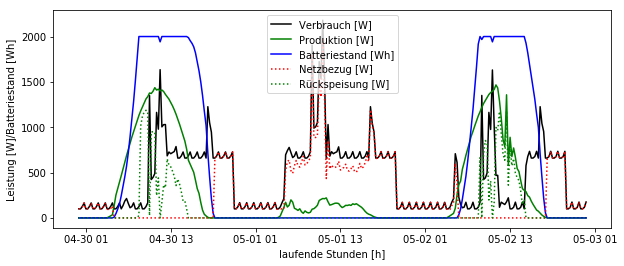

In [13]:
### es wird nur ein Ausschnitt betrachtet, nicht das gesamte Jahr
a  = int(105*24/deltaT)
e  = int(a+3*24/deltaT)
pPV      = hGlo[a:e]*PR*pPVstc  # [W]
pVer     = pLoad[a:e]
tutcTeil = tutc[a:e]

# Initialisierung Array für Darstellung (***)
batStand      = np.zeros(tutcTeil.size) # Array für Batteriestand
netzbezug     = np.zeros(tutcTeil.size) # Array für Netzleistungsbezug
einspeisung   = np.zeros(tutcTeil.size) # Array für Einspeiseleistung

### Batterie Berechnung
wBez  = 0    # [kWh] Energie Netzbezug
wEin  = 0    # [kWh] Energie Netzeinspeisung   
wBat  = 0    # [kWh] Energie Batteriestand. Annahme das Batterie zu Beginn leer ist

pBedarf = pVer-pPV  # [W] Bedarf ist Verbrauch agzüglich Produktion, jedoch....
pBedarf[pBedarf<0]=0 #...darf der Wert nicht <0 sein (z.B. wenn PV grösser ist als Verbrauch)
for p in range(pPV.size):
    if wBat >= pBedarf[p]*deltaT/1000:
        wBat = wBat - pBedarf[p]*deltaT/1000    # [kWh]
        pBezug = 0                           # [kW] (***)
    else:
        wBez = wBez + pBedarf[p]*deltaT/1000 - wBat   # [kWh]
        wBat  = 0
        pBezug = pBedarf[p] - wBat*1000/deltaT   # [W] (***)
    pUebersch = np.maximum(pPV[p]-pVer[p], 0) # [W]      
    if wBat <= batCap:
        eNichtladbar = np.maximum(pUebersch*deltaT/1000 - (batCap-wBat),0) #[kWh]
        wBat = wBat + pUebersch*deltaT/1000 - eNichtladbar                 #[kWh] 
        wEin = wEin + eNichtladbar
        pEinspeisung = eNichtladbar/deltaT*1000  # [W] (***)
    else:
        wEin = wEin + pUebersch*deltaT/1000   # [kWh]
        pEinspeisung = pUebersch              # [W] (***)
    
    # Berechnete Werte ans Array übergeben (***)
    batStand[p]  = wBat*1000
    netzbezug[p]   = pBezug       # [W] (***)
    einspeisung[p] = pEinspeisung # [W] (***)
 
### Darstellung (***)
fig = plt.figure(6, figsize=(10,4))
plt.plot_date(tutcTeil, pVer,'k', label='Verbrauch [W]')
plt.plot_date(tutcTeil, pPV,'g', label='Produktion [W]')
plt.plot_date(tutcTeil, batStand,'b', label='Batteriestand [Wh]')
plt.plot_date(tutcTeil, netzbezug,'r:', label='Netzbezug [W]')
plt.plot_date(tutcTeil, einspeisung,'g:', label='Rückspeisung [W]')
plt.legend(loc='best')
plt.xlabel('laufende Stunden [h]')
plt.ylabel('Leistung [W]/Batteriestand [Wh]')
plt.show()

### Thermischer Speicher
Mit der selben Logik kann ein thermischer Speicher (Boiler) berechnet werden. Es wird von einer vollständigen Durchmischung im Speicher ausgegangen, d.h. es gibt keine Schichtung. Bei einem Energieeintrag erhöht sich die Temperatur im Speicher, was in der Praxis einer Stufenladung entspricht und keiner Schichtladung, da von keiner Schichtung ausgegangen wird.

Der Energieinhalt berechnet sich über die Speichertemperatur tsp, Kaltwassertemperatur tkw, der Dichte $\rho$ und der spezifischen Wärmekapazität von Wasser cp = 4.182 kJ/(kg K):

$W = vol \cdot \rho \cdot cp \cdot (tsp - tkw)$

Der Speicher hat folgendes Steuerverhalten: bei einer minimalen Speichertemperatur von tMin = 40 °C, wird der Heizstab über das Netz versorgt, sodass ausreichend Warmwasser erzeugt wird. Ist die Nachladung über das Netz aktiviert so bleibt diese aktiv bis der Speicher eine Temperatur von tMaxNetz = 45 °C hat (Hysteresis). Wird über PV geladen so ist die Ausschaltschwelle höher bei tMax     = 85 °C. Es kann so mehr Energie eingelagert werden. Zu berücksichtigen sind Speicherverluste von 23 W. 

In [14]:
### Thermische Speicher Berechnung
vol      = 300 # [liter] Speicherinhalt
tkw      = 12  # [°C] Kaltwassertemperatur
tMin     = 40  # [°C] min. Speichertemp. Heizung ein
tMax     = 85  # [°C] max. Speichertemp. bei PV-Ladung
tMaxNetz = 45  # [°C] max. Speichertemp. bei Netz-Ladung
thermalLosses = 23 # [W] Speicherverluste 
pHS           = 2  # [kW] Leistung Heizstab

tSp  = 45 # [°C] Sim.Starttemperatur Speicher       
wBez = 0  # [kWh] Energie Netzbezug
netzLaden = False # Flag welches Netzladung anzeigt
tSpArray = np.zeros(zapf.size)   # [°C] Array für Speichertemperatur
pThermArray = np.zeros(zapf.size)# [W] Array Leistung Heizstab
pzapfArray = np.zeros(zapf.size) # [W] Array Zapf-Leistung     

for p in range(pPV.size):
    if tSp < tMax:
        pTherm = pPV[p] # [W]
    else:
        pTherm = 0 # [W]

    if tSp > tMaxNetz:
        netzLaden = False

    if tSp < tMin:
        netzLaden = True

    if netzLaden == True:
        wBez = wBez + pHS*deltaT # [kWh]
        pTherm = pHS*1000 + pTherm # [W]

    wSp   = vol * 4.182/3.6 * (tSp-tkw) # [Wh] Energieinhalt Speicher vorher
    pzapf = zapf[p]/deltaT * 4.182/3.6 * (tSp-tkw) # [W_therm] gezapfte Leistung
    wSp   = wSp + (pTherm - pzapf - thermalLosses)*deltaT  # [Wh] Energieinhalt Speicher nachher
    tSp = wSp/(vol*4.182/3.6) + tkw # [°C]  neue Speichertemperatur
    tSpArray[p] = tSp # [°C]
    pThermArray[p] = pTherm # [W]
    pzapfArray[p] = pzapf # [W]

Dieses Tutorial wurde mit Jupyter Notebook erstellt, welches ebenfalls in Anaconda-Paket enthalten ist. Markus Markstaler.